# Imports

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import gensim.downloader as api

# Data Loading

In [3]:
## Load cleaned data
X_reviews = pd.read_csv("/Users/egmac/code/arostagnat/BookMatch/data/proc_data/X_cluster_69.csv")

In [4]:
## Load metadata
metadata_movies = pd.read_json("/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_movies/metadata.json", lines=True)
metadata_books = pd.read_json("/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_book/metadata.json", lines=True)

In [5]:
# Adjust metadata columns to match X_reviews
metadata_movies.rename({"item_id":"item_id_movie", "title":"title_movie"}, axis='columns',inplace=True)
metadata_books.rename({"item_id":"item_id_book", "title":"title_book","img":"img_book","url":"url_book"}, axis='columns',inplace=True)

In [6]:
## Adjust import to replace $$$ with 0, and convert item_id to float to enable merge. 
## Note that the X_reviews import is preformatted as a float
# X_reviews = X_reviews.replace({'$$$': 0}, regex=False)
X_reviews.item_id_movie = X_reviews.item_id_movie.astype(float)
X_reviews.item_id_book = X_reviews.item_id_book.astype(float)

In [7]:
## Revise metadata item_id to float to match X_reviews
metadata_movies.item_id_movie = metadata_movies.item_id_movie.astype(float)
metadata_books.item_id_book = metadata_books.item_id_book.astype(float)

In [8]:
## Merge X_reviews and metadata
X_all = pd.merge(X_reviews, metadata_movies[["title_movie","item_id_movie"]], on="item_id_movie", how="left")
X_all = pd.merge(X_all, metadata_books[["title_book","item_id_book","url_book","img_book"]], on="item_id_book", how="left")

In [9]:
## Check import
X_all.head(1)

,item_id_movie,is_movie,item_id_book,clustering_label_bert,vector,title_movie,title_book,url_book,img_book
0,2.0,1,-1.0,9,"[-0.044011011719703674, 0.023551730439066887, ...",Jumanji (1995),NaN,NaN,NaN


# Recommendation

In [10]:
## Import relevant packages

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [89]:
## Create extract of X_all with vectors spread across columns, and confirm relevance of dimensions
## Vectors have to be reformatted as lists, as they are formatted as strings with ""

vectors = X_all.vector.tolist()
vectors_revised = []

for vector in vectors:
    result = vector.strip('[]').replace("'","").replace(' ', '').split(',')
    result = [float(i) for i in result]
    vectors_revised.append(result)

X_vectors = pd.DataFrame(vectors_revised)

In [90]:
svd = TruncatedSVD(n_components=X_vectors.shape[1])
svd_result = svd.fit_transform(X_vectors)

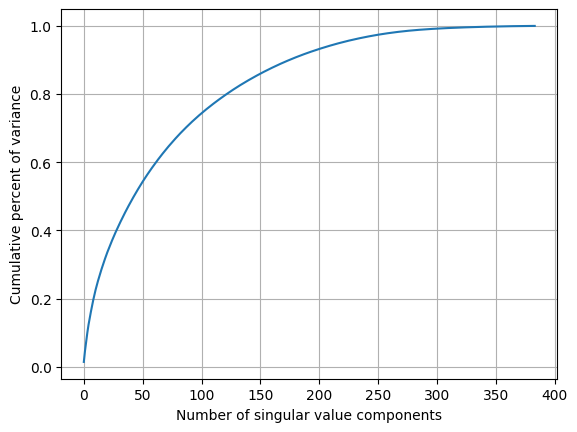

In [91]:
## Plot variance as a function of the number of components.
## Based on the below figure, nearly 100% of the variance is explained by 250 components
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('Number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [92]:
## Reshape vectors to 250 components, which will help reduce computational time
n = 250
X_vectors_revised = pd.DataFrame(X_vectors.iloc[:,0:n])
print(f'X_all shape: {X_all.shape} | X_vectors shape: {X_vectors.shape} | X_vectors_revised shape: {X_vectors_revised.shape}')

X_all shape: (4213, 9) | X_vectors shape: (4213, 384) | X_vectors_revised shape: (4213, 250)


In [93]:
## Add qualitative columns to X_vectors_revised, and then create 2 separate dataframes for books and movies.
## Movie dataframe to be used to lookup user-inputted movies. Book dataframe to be used for calculations.
## Note that the dataframes need to be separated eventually, so it's worth doing now.

X_vectors_revised[["item_id_movie","item_id_book","is_movie"]] = X_all[["item_id_movie","item_id_book","is_movie"]]

X_vectors_books = X_vectors_revised[X_vectors_revised.is_movie == 0].set_index("item_id_book",drop=True).drop(columns=["item_id_movie","is_movie"])
X_vectors_movies = X_vectors_revised[X_vectors_revised.is_movie == 1].set_index("item_id_movie",drop=True).drop(columns=["item_id_book","is_movie"])

In [255]:
## Input sample data
user_movies = [5816,40815,54001,69844]
## [5816,40815,54001,69844]

In [94]:
## Method 1: For each film in user list, calculate the cosine similarity with all books in the cluster
## Then, sort the books by their cosine similarity to identify **the** **closest** book for each film
## Finally, take the full list of book recommendations and then identify the **top 5 most frequent** books

def get_local_reccs(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    recommendations = pd.DataFrame(columns=["similarity","title_book","img_book","url_book"])
    movies = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies = pd.merge(movies,X_all[["title_movie","item_id_movie"]],on="item_id_movie",how="left")
    
    for movie_id in verified_movies:

        # Obtain vectors for user-inputted film and all books. Clusters are not used for time being
        ### movie_cluster = X_vectors_movies[X_vectors_movies.index == movie_id].cluster_bert.values[0]
        movie_vector = X_vectors_movies[X_vectors_movies.index == movie_id]
        books_vectors = X_vectors_books

        # Calculate cosine similarity
        sim_books = cosine_similarity(books_vectors,movie_vector)
 
        # Create summary table of books with their similarity and relevant details
        sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
        sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
        sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],
                                    on="item_id_book",how="left")

        # Add top book to recommendations dataframe
        top_book = pd.DataFrame([sim_books_detail.loc[0]])
        recommendations = pd.concat([recommendations,top_book],axis=0, ignore_index=True)
    
    print("Inputted films")
    print(movies)
    return recommendations["title_book"]


In [95]:
## Method 2: Calculate the average vector for all films in the user list, and then identify the corresponding cluster
## Then,calculate the cosine similarity with all books in the cluster
## Finally, sort the books by their cosine similarities and take the **top 5 closest** books

def get_global_reccs(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    ## Collect vectors of all inputted films and calculate average vector
    movies_id = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies_vectors = pd.merge(movies_id,
                              X_vectors_movies,
                              how="left",
                              on="item_id_movie").set_index("item_id_movie")
    avg_movie_vector = pd.DataFrame([movies_vectors.mean(numeric_only=True)])
    books_vectors = X_vectors_books

    ## Calculate cosine similarity
    sim_books = cosine_similarity(books_vectors,avg_movie_vector)

    ## Create summary table of books with their similarity and relevant details
    sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
    sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
    sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],on="item_id_book",how="left")
    
    ## Take top 5 books and show results
    recommendations = sim_books_detail.head(5)
    movie_titles = pd.merge(movies_id,X_all[["title_movie","item_id_movie"]],how="inner",on="item_id_movie")
    print("Inputted films")
    print(movie_titles.title_movie)
    print ("Top 5 book recommendations")
    return recommendations["title_book"]

In [96]:
get_local_reccs([1,2,3,4,5,6,7])

Inputted films
   item_id_movie               title_movie
0              2            Jumanji (1995)
1              4  Waiting to Exhale (1995)
2              6               Heat (1995)


0    Harry Potter and the Order of the Phoenix (Har...
1    Harry Potter and the Half-Blood Prince (Harry ...
2    Harry Potter and the Order of the Phoenix (Har...
Name: title_book, dtype: object

In [75]:
user_movies = [1,2,3,4,5,6,7]
verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
movies_id = pd.DataFrame(verified_movies,columns=["item_id_movie"])
movies_vectors = pd.merge(movies_id,
                          X_vectors_movies,
                          how="left",
                          on="item_id_movie").set_index("item_id_movie")
avg_movie_vector = pd.DataFrame([movies_vectors.mean(numeric_only=True)])
books_vectors = X_vectors_books

In [97]:
get_global_reccs([1,2,3,4,5,6,7])

Inputted films
0              Jumanji (1995)
1    Waiting to Exhale (1995)
2                 Heat (1995)
Name: title_movie, dtype: object
Top 5 book recommendations


0    Harry Potter and the Order of the Phoenix (Har...
1    Harry Potter and the Sorcerer's Stone (Harry P...
2    Harry Potter and the Half-Blood Prince (Harry ...
Name: title_book, dtype: object